Install biosppy library

In [ ]:
!pip install biosppy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 4.1 MB/s eta 0:00:00


In [ ]:
!pip install peakutils

ECG FILTERED WITH MITTAGE LEFFLER FILTER ON FIRST DATA SET

In [ ]:
# === INSTALL & IMPORTS ===
import json
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
from scipy.signal import find_peaks, butter, filtfilt
from biosppy.signals import ecg as biosppy_ecg

# === Mount Google Drive ===
drive.mount('/content/drive')

# === Load JSON Data ===
filename = "/content/drive/My Drive/Data/data/15.json"
with open(filename, 'r') as f:
    data = json.load(f)

# === Extract ECG Signal ===
ecg = np.array(data['data_ECG'])
t = np.arange(len(ecg))

# === Mittag–Leffler Inspired Filter ===
def mittag_leffler_filter(signal, alpha=0.9, gamma=1.2):
    output = np.zeros_like(signal)
    output[0] = signal[0]
    for i in range(1, len(signal)):
        output[i] = (1 - alpha) * signal[i] + alpha * output[i - 1] * np.exp(-gamma * (1 - alpha))
    return output

# === Apply Filtering ===
ecg_filtered = mittag_leffler_filter(ecg)

# === Match Power to Raw ECG ===
def match_signal_power(reference_signal, target_signal):
    ref_power = np.mean(reference_signal ** 2)
    tgt_power = np.mean(target_signal ** 2)
    scaling_factor = np.sqrt(ref_power / tgt_power)
    return target_signal * scaling_factor

ecg_lowpassed = match_signal_power(ecg, ecg_filtered)

# === Detect Downward Peaks (Valleys) ===
inverted_ecg = -ecg_lowpassed
downward_peaks, _ = find_peaks(inverted_ecg, distance=10, prominence=0.001)

# === Detect R-Peaks using biosppy ===
ecg_analysis = biosppy_ecg.ecg(signal=ecg_lowpassed, sampling_rate=1000, show=False)
r_peaks = ecg_analysis['rpeaks']

# === SNR Calculation ===
def calculate_snr(signal, reference):
    noise = signal - reference
    power_signal = np.mean(reference ** 2)
    power_noise = np.mean(noise ** 2)
    snr = 10 * np.log10(power_signal / power_noise)
    return snr

snr_value = calculate_snr(ecg, ecg_lowpassed)
print(f"SNR between raw and filtered ECG: {snr_value:.2f} dB")

# === Butterworth Low-Pass Filter Function ===
def butter_lowpass_filter(data, cutoff=30, fs=1000, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# === Interactive Zoom Plot With Highlighting and Selective Filtering ===
def zoom_plot(start=0, width=5000):
    end = min(start + width, len(ecg))
    t_zoom = t[start:end]
    ecg_zoom = ecg_lowpassed[start:end]

    downward_zoom = [i for i in downward_peaks if start <= i < end]
    r_peaks_zoom = [i for i in r_peaks if start <= i < end]

    downward_in_range = np.array(downward_peaks)
    nearest_downward_peaks = set()

    for r in r_peaks_zoom:
        left_candidates = downward_in_range[downward_in_range < r]
        right_candidates = downward_in_range[downward_in_range > r]
        if len(left_candidates) > 0:
            nearest_left = left_candidates[-1]
            if start <= nearest_left < end:
                nearest_downward_peaks.add(nearest_left)
        if len(right_candidates) > 0:
            nearest_right = right_candidates[0]
            if start <= nearest_right < end:
                nearest_downward_peaks.add(nearest_right)

    nearest_downward_peaks = sorted(nearest_downward_peaks)

    # Identify valid yellow-to-yellow intervals without any red dot
    valid_intervals = []
    for i in range(len(nearest_downward_peaks) - 1):
        y1 = nearest_downward_peaks[i]
        y2 = nearest_downward_peaks[i + 1]
        if not any((y1 < r < y2) for r in r_peaks_zoom):
            valid_intervals.append((y1, y2))

    # === Apply lowpass filter only inside valid intervals ===
    ecg_region_filtered = ecg_lowpassed.copy()
    for y1, y2 in valid_intervals:
        segment = ecg_region_filtered[y1:y2]
        filtered_segment = butter_lowpass_filter(segment, cutoff=30, fs=1000, order=4)
        ecg_region_filtered[y1:y2] = filtered_segment

    # === Plotting ===
    plt.figure(figsize=(12, 4))
    plt.plot(t_zoom, ecg_region_filtered[start:end], label='Regionally Filtered ECG', color='green')
    plt.plot(t[r_peaks_zoom], ecg_region_filtered[r_peaks_zoom], 'ro', label='R Peaks (biosppy)')
    plt.plot(t[nearest_downward_peaks], ecg_region_filtered[nearest_downward_peaks], 'yo', label='Nearest Downward Peaks')

    for y1, y2 in valid_intervals:
        plt.axvspan(t[y1], t[y2], color='yellow', alpha=0.3)

    plt.title(f'Zoomed ECG with Selective Smoothing [{start}:{end}]')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Sliders for Zoom Range ===
interact(zoom_plot,
         start=IntSlider(min=0, max=len(ecg)-1000, step=500, value=0, description='Zoom Start'),
         width=IntSlider(min=1000, max=30000, step=1000, value=5000, description='Zoom Width'));


Mounted at /content/drive
SNR between raw and filtered ECG: 33.38 dB


interactive(children=(IntSlider(value=0, description='Zoom Start', max=354000, step=500), IntSlider(value=5000…

In [ ]:
from scipy.signal import butter, filtfilt, savgol_filter

# Butterworth filter function (if not already defined)
def butter_lowpass_filter(data, cutoff=30, fs=1000, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Final zoom_plot function with raw + smoothed plot
def zoom_plot(start=0, width=5000):
    end = min(start + width, len(ecg))
    t_zoom = t[start:end]
    ecg_raw_zoom = ecg[start:end]
    ecg_zoom = ecg_lowpassed[start:end]

    downward_zoom = [i for i in downward_peaks if start <= i < end]
    r_peaks_zoom = [i for i in r_peaks if start <= i < end]

    downward_in_range = np.array(downward_peaks)
    nearest_downward_peaks = set()

    for r in r_peaks_zoom:
        left_candidates = downward_in_range[downward_in_range < r]
        right_candidates = downward_in_range[downward_in_range > r]
        if len(left_candidates) > 0:
            nearest_left = left_candidates[-1]
            if start <= nearest_left < end:
                nearest_downward_peaks.add(nearest_left)
        if len(right_candidates) > 0:
            nearest_right = right_candidates[0]
            if start <= nearest_right < end:
                nearest_downward_peaks.add(nearest_right)

    nearest_downward_peaks = sorted(nearest_downward_peaks)

    # Valid intervals (yellow regions without R-peaks)
    valid_intervals = []
    for i in range(len(nearest_downward_peaks) - 1):
        y1 = nearest_downward_peaks[i]
        y2 = nearest_downward_peaks[i + 1]
        if not any((y1 < r < y2) for r in r_peaks_zoom):
            valid_intervals.append((y1, y2))

    # Apply selective smoothing
    ecg_region_filtered = ecg_lowpassed.copy()
    for y1, y2 in valid_intervals:
        segment = ecg_region_filtered[y1:y2]
        if len(segment) < 11:
            continue
        lowpassed = butter_lowpass_filter(segment, cutoff=30, fs=1000, order=4)
        smoothed = savgol_filter(lowpassed, window_length=50, polyorder=3, mode='interp')
        ecg_region_filtered[y1:y2] = smoothed

    ecg_smooth_zoom = ecg_region_filtered[start:end]

    # === Plotting ===
    fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

    # Top: Raw ECG
    axs[0].plot(t_zoom, ecg_raw_zoom, color='gray', label='Raw ECG')
    axs[0].set_title('Zoomed Raw ECG')
    axs[0].set_ylabel('Amplitude')
    axs[0].grid(True)
    axs[0].legend()

    # Bottom: Filtered ECG with highlights
    axs[1].plot(t_zoom, ecg_smooth_zoom, label='Filtered + Savitzky–Golay', color='green')
    axs[1].plot(t[r_peaks_zoom], ecg_region_filtered[r_peaks_zoom], 'ro', label='R Peaks')
    axs[1].plot(t[nearest_downward_peaks], ecg_region_filtered[nearest_downward_peaks], 'yo', label='Nearest Downward Peaks')

    for y1, y2 in valid_intervals:
        axs[1].axvspan(t[y1], t[y2], color='yellow', alpha=0.3)

    axs[1].set_title(f'Zoomed Filtered ECG with Highlighted Regions [{start}:{end}]')
    axs[1].set_xlabel('Sample Index')
    axs[1].set_ylabel('Amplitude')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # === Sliders for Zoom Range ===
interact(zoom_plot,
         start=IntSlider(min=0, max=len(ecg)-1000, step=500, value=0, description='Zoom Start'),
         width=IntSlider(min=1000, max=30000, step=1000, value=5000, description='Zoom Width'));



interactive(children=(IntSlider(value=0, description='Zoom Start', max=354000, step=500), IntSlider(value=5000…

ECG FILTERED WITH MITTAGE LEFFLER FILTER ON SECOND DATA SET

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 89.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


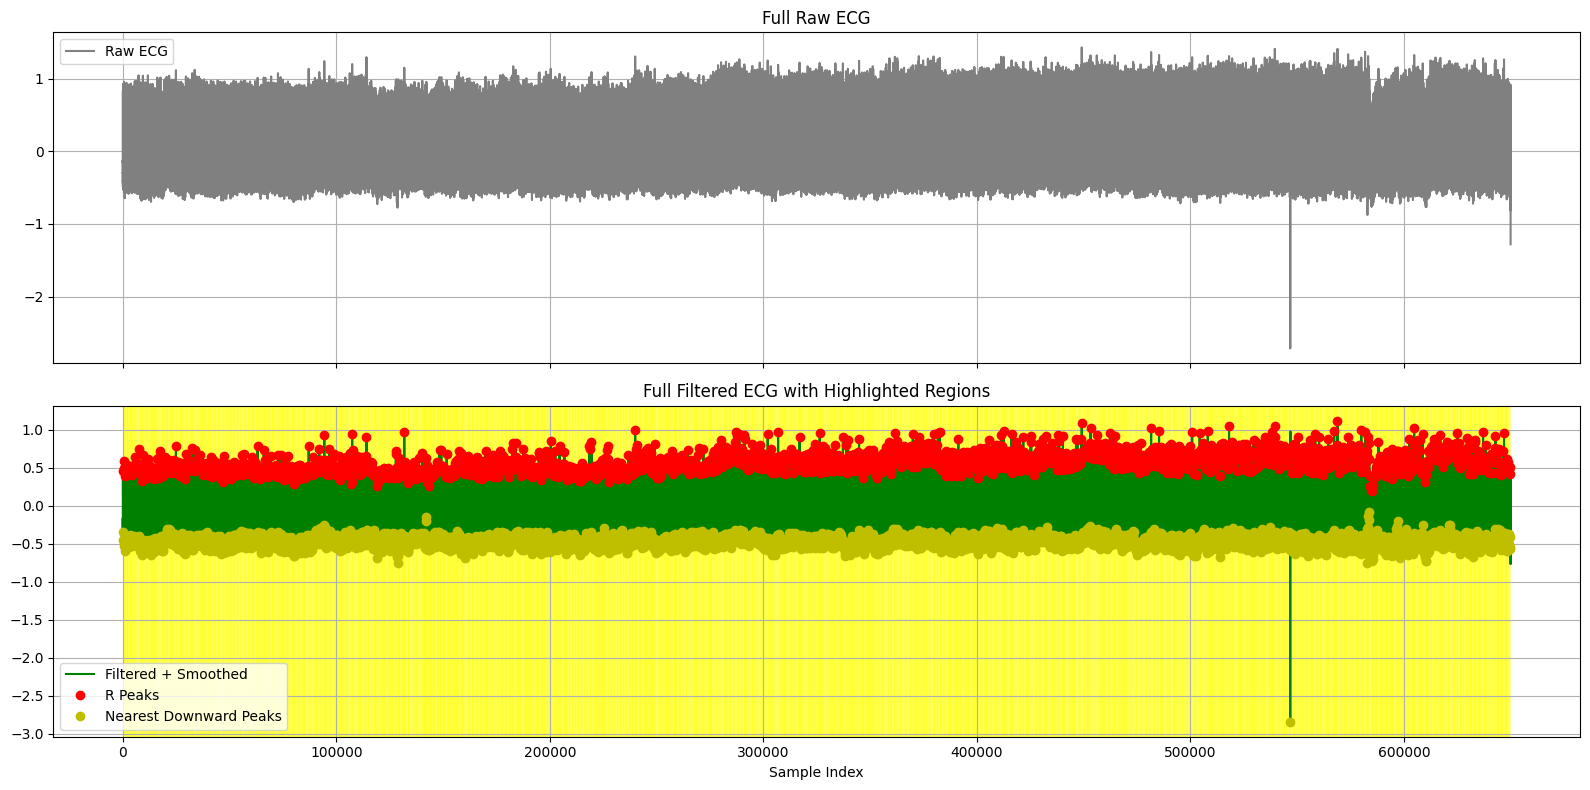

SNR between raw and filtered ECG: 10.14 dB


interactive(children=(IntSlider(value=0, description='Zoom Start', max=649000, step=500), IntSlider(value=5000…

In [ ]:
# === INSTALL & IMPORTS ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, savgol_filter
from biosppy.signals import ecg as biosppy_ecg
from google.colab import drive
from ipywidgets import interact, IntSlider
import wfdb

# === Mount Drive ===
drive.mount('/content/drive')

# === Load ECG Signal from WFDB ===
record_path = "/content/drive/My Drive/Data/100"  # Adjust path
record = wfdb.rdrecord(record_path)
ecg = record.p_signal[:, 0]
fs = record.fs
t = np.arange(len(ecg))

# === Filtering Functions ===
def butter_lowpass_filter(data, cutoff=30, fs=1000, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def mittag_leffler_filter(signal, alpha=0.9, gamma=1.2):
    output = np.zeros_like(signal)
    output[0] = signal[0]
    for i in range(1, len(signal)):
        output[i] = (1 - alpha) * signal[i] + alpha * output[i - 1] * np.exp(-gamma * (1 - alpha))
    return output

def match_signal_power(reference, target):
    ref_power = np.mean(reference ** 2)
    tgt_power = np.mean(target ** 2)
    return target * np.sqrt(ref_power / tgt_power)

# === Apply Filtering ===
ecg_filtered = mittag_leffler_filter(ecg)
ecg_lowpassed = match_signal_power(ecg, ecg_filtered)

# === Detect R-peaks and Valleys ===
inverted_ecg = -ecg_lowpassed
downward_peaks, _ = find_peaks(inverted_ecg, distance=30, prominence=0.01)
r_peaks = biosppy_ecg.ecg(signal=ecg_lowpassed, sampling_rate=fs, show=False)['rpeaks']

# === SNR Calculation ===
def calculate_snr(signal, reference):
    noise = signal - reference
    return 10 * np.log10(np.mean(reference**2) / np.mean(noise**2))

# === Smoothing Between Valleys Not Including R-peaks ===
ecg_region_filtered = ecg_lowpassed.copy()
nearest_downward_peaks = set()
down_peaks_array = np.array(downward_peaks)

for r in r_peaks:
    left = down_peaks_array[down_peaks_array < r]
    right = down_peaks_array[down_peaks_array > r]
    if len(left): nearest_downward_peaks.add(left[-1])
    if len(right): nearest_downward_peaks.add(right[0])
nearest_downward_peaks = sorted(nearest_downward_peaks)

valid_intervals = []
for i in range(len(nearest_downward_peaks) - 1):
    y1, y2 = nearest_downward_peaks[i], nearest_downward_peaks[i + 1]
    if not any((y1 < r < y2) for r in r_peaks):
        valid_intervals.append((y1, y2))

for y1, y2 in valid_intervals:
    segment = ecg_region_filtered[y1:y2]
    seg_len = len(segment)
    if seg_len < 11: continue
    win_len = min(51, seg_len if seg_len % 2 == 1 else seg_len - 1)
    if win_len < 5: continue
    lowpassed = butter_lowpass_filter(segment, cutoff=30, fs=fs, order=4)
    smoothed = savgol_filter(lowpassed, window_length=win_len, polyorder=3, mode='interp')
    ecg_region_filtered[y1:y2] = smoothed

# === Plot Full Signal ===
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
axs[0].plot(t, ecg, color='gray', label='Raw ECG')
axs[0].set_title('Full Raw ECG')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, ecg_region_filtered, color='green', label='Filtered + Smoothed')
axs[1].plot(t[r_peaks], ecg_region_filtered[r_peaks], 'ro', label='R Peaks')
axs[1].plot(t[nearest_downward_peaks], ecg_region_filtered[nearest_downward_peaks], 'yo', label='Nearest Downward Peaks')
for y1, y2 in valid_intervals:
    axs[1].axvspan(t[y1], t[y2], color='yellow', alpha=0.3)

axs[1].set_title('Full Filtered ECG with Highlighted Regions')
axs[1].set_xlabel('Sample Index')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()

# === SNR Print ===
snr_val = calculate_snr(ecg, ecg_region_filtered)
print(f"SNR between raw and filtered ECG: {snr_val:.2f} dB")

# === Zoom Function ===
def zoom_plot(start=0, width=5000):
    end = min(start + width, len(ecg))
    t_zoom = t[start:end]
    ecg_raw_zoom = ecg[start:end]
    ecg_zoom = ecg_lowpassed[start:end]

    downward_zoom = [i for i in downward_peaks if start <= i < end]
    r_peaks_zoom = [i for i in r_peaks if start <= i < end]

    down_in_range = np.array(downward_peaks)
    nearest_zoom = set()
    for r in r_peaks_zoom:
        left = down_in_range[down_in_range < r]
        right = down_in_range[down_in_range > r]
        if len(left): nearest_zoom.add(left[-1])
        if len(right): nearest_zoom.add(right[0])
    nearest_zoom = sorted([i for i in nearest_zoom if start <= i < end])

    intervals = []
    for i in range(len(nearest_zoom) - 1):
        y1, y2 = nearest_zoom[i], nearest_zoom[i + 1]
        if not any((y1 < r < y2) for r in r_peaks_zoom):
            intervals.append((y1, y2))

    ecg_filtered_zoom = ecg_lowpassed.copy()
    for y1, y2 in intervals:
        segment = ecg_filtered_zoom[y1:y2]
        seg_len = len(segment)
        if seg_len < 11: continue
        win_len = min(27, seg_len if seg_len % 2 == 1 else seg_len - 1)
        if win_len < 5: continue
        lowpassed = butter_lowpass_filter(segment, cutoff=30, fs=fs, order=4)
        smoothed = savgol_filter(lowpassed, window_length=win_len, polyorder=3, mode='interp')
        ecg_filtered_zoom[y1:y2] = smoothed

    fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    axs[0].plot(t_zoom, ecg_raw_zoom, color='gray', label='Raw ECG')
    axs[0].set_title("Zoomed Raw ECG")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(t_zoom, ecg_filtered_zoom[start:end], color='green', label='Filtered + Smoothed')
    axs[1].set_title("Zoomed Filtered ECG")
    for y1, y2 in intervals:
        axs[1].axvspan(t[y1], t[y2], color='yellow', alpha=0.3)
    axs[1].grid(True)
    axs[1].legend()
    plt.tight_layout()
    plt.show()

# === Interactive Zoom Plot ===
interact(zoom_plot,
         start=IntSlider(min=0, max=len(ecg)-1000, step=500, value=0, description='Zoom Start'),
         width=IntSlider(min=1000, max=30000, step=1000, value=5000, description='Zoom Width'));


ECG PREPROCESSED WITH MEDIAN FILTER ON FIRST DATA SET

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


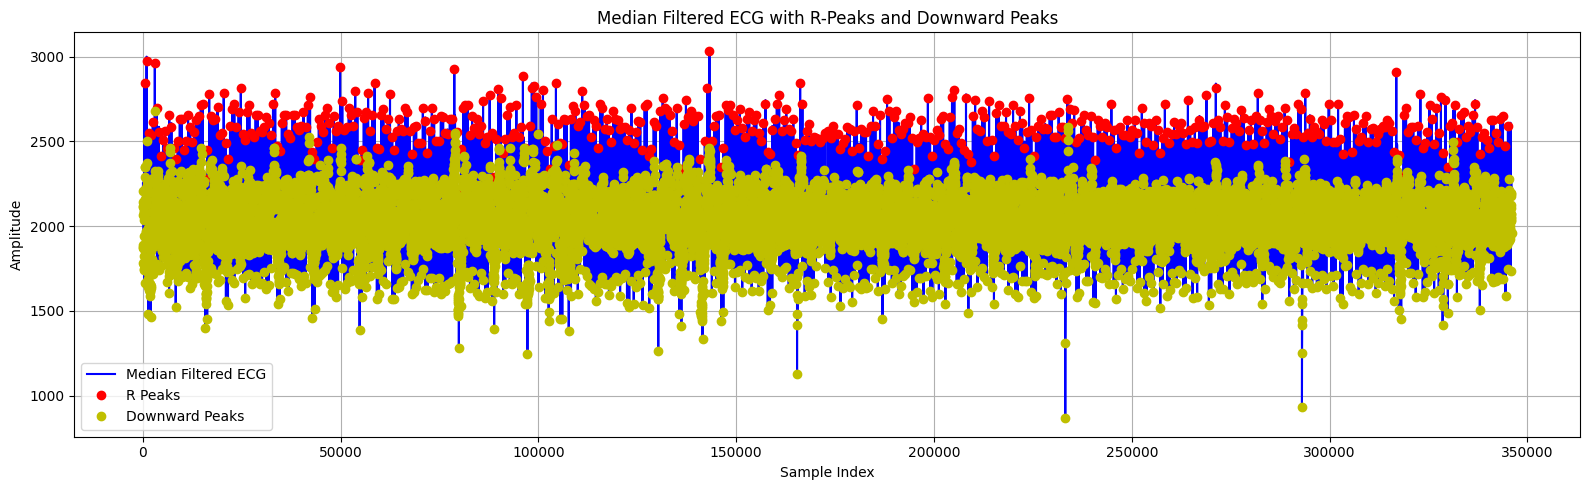

SNR between raw and median-filtered ECG: 39.32 dB
SNR after smoothing: 35.51 dB


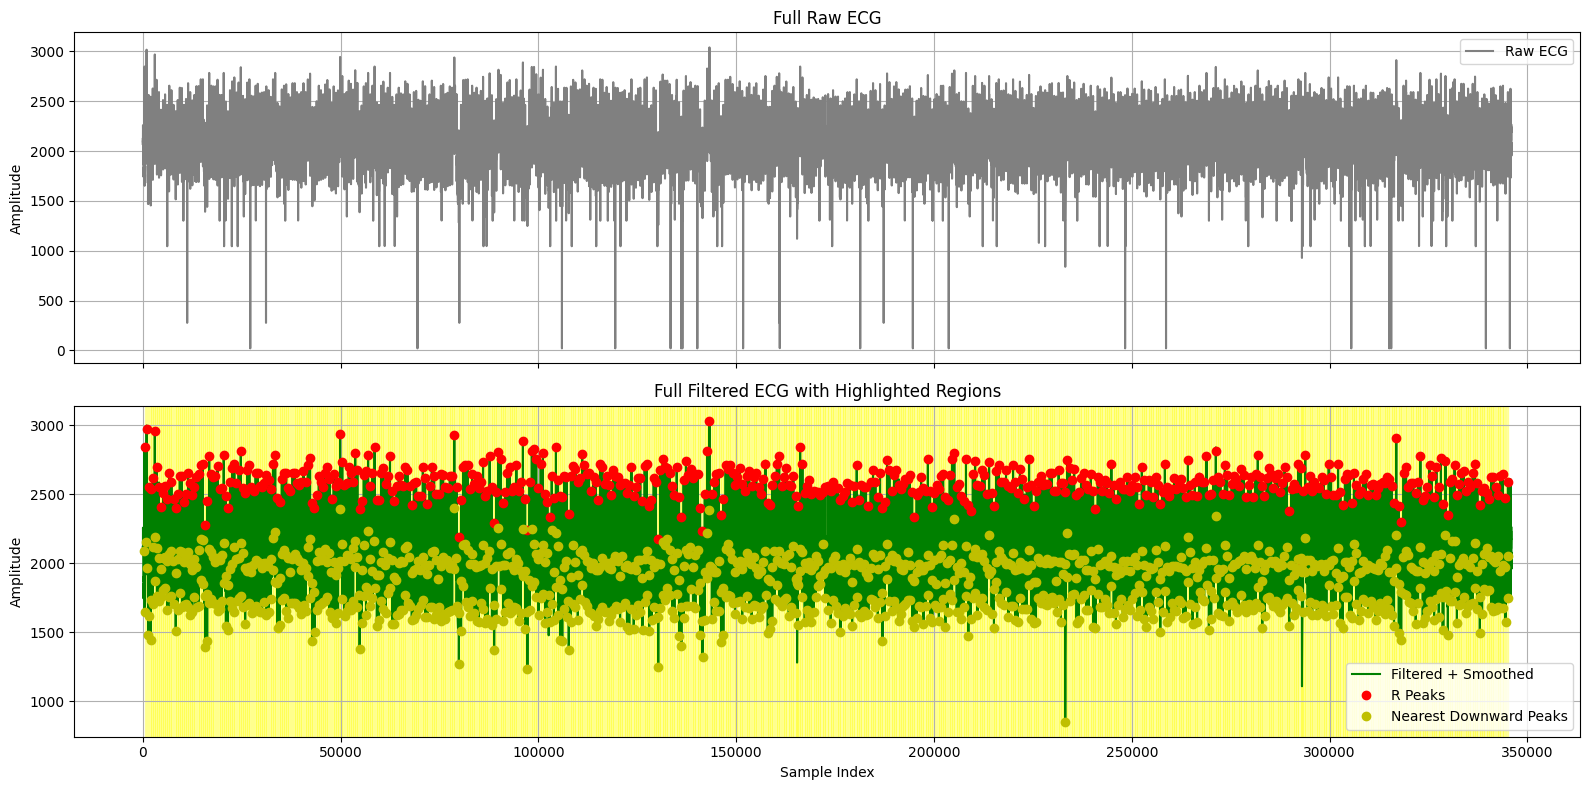

interactive(children=(IntSlider(value=0, description='Zoom Start', max=345000, step=500), IntSlider(value=5000…

In [ ]:
# === INSTALL & IMPORTS ===
import json
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
from scipy.signal import find_peaks, butter, filtfilt, savgol_filter, medfilt
from biosppy.signals import ecg as biosppy_ecg

# === Mount Google Drive ===
drive.mount('/content/drive')

# === Load JSON Data ===
filename = "/content/drive/My Drive/Data/data/18.json"
with open(filename, 'r') as f:
    data = json.load(f)

# === Extract ECG Signal ===
ecg = np.array(data['data_ECG'])
t = np.arange(len(ecg))

# === Butterworth filter function ===
def butter_lowpass_filter(data, cutoff=30, fs=1000, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# === Apply Median Filter ===
kernel_size = 5  # Must be odd and >= 3
ecg_filtered = medfilt(ecg, kernel_size=kernel_size)


# === Detect Downward Peaks (Valleys) ===
inverted_ecg = -ecg_filtered
downward_peaks, _ = find_peaks(inverted_ecg, distance=10, prominence=0.001)

# === Detect R-Peaks using biosppy ===
ecg_analysis = biosppy_ecg.ecg(signal=ecg_filtered, sampling_rate=1000, show=False)
r_peaks = ecg_analysis['rpeaks']

# === Full ECG Plot after Median Filtering with R-Peaks and Downward Peaks ===
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(t, ecg_filtered, color='blue', label='Median Filtered ECG')
ax.plot(r_peaks, ecg_filtered[r_peaks], 'ro', label='R Peaks')
ax.plot(downward_peaks, ecg_filtered[downward_peaks], 'yo', label='Downward Peaks')

ax.set_title('Median Filtered ECG with R-Peaks and Downward Peaks')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Amplitude')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# === SNR Calculation ===
def calculate_snr(signal, reference):
    noise = signal - reference
    power_signal = np.mean(reference ** 2)
    power_noise = np.mean(noise ** 2)
    snr = 10 * np.log10(power_signal / power_noise)
    return snr

snr_value = calculate_snr(ecg, ecg_filtered)
print(f"SNR between raw and median-filtered ECG: {snr_value:.2f} dB")

# === Full ECG Filtered Plot with Annotations ===
ecg_region_filtered = ecg_filtered.copy()

# Find nearest downward peaks for all R-peaks
nearest_downward_peaks = set()
downward_in_range = np.array(downward_peaks)

for r in r_peaks:
    left = downward_in_range[downward_in_range < r]
    right = downward_in_range[downward_in_range > r]
    if len(left) > 0:
        nearest_downward_peaks.add(left[-1])
    if len(right) > 0:
        nearest_downward_peaks.add(right[0])

nearest_downward_peaks = sorted(nearest_downward_peaks)

# Find valid intervals
valid_intervals = []
for i in range(len(nearest_downward_peaks) - 1):
    y1 = nearest_downward_peaks[i]
    y2 = nearest_downward_peaks[i + 1]
    if not any((y1 < r < y2) for r in r_peaks):
        valid_intervals.append((y1, y2))

# Apply smoothing in valid intervals
for y1, y2 in valid_intervals:
    segment = ecg_region_filtered[y1:y2]
    seg_len = len(segment)
    if seg_len < 11:
        continue
    win_len = min(51, seg_len if seg_len % 2 == 1 else seg_len - 1)
    if win_len < 5:
        continue
    lowpassed = butter_lowpass_filter(segment, cutoff=20, fs=1000, order=4)
    smoothed = savgol_filter(lowpassed, window_length=win_len, polyorder=3, mode='interp')
    ecg_region_filtered[y1:y2] = smoothed

# === Plot Full ECG ===
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

axs[0].plot(t, ecg, color='gray', label='Raw ECG')
axs[0].set_title('Full Raw ECG')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, ecg_region_filtered, color='green', label='Filtered + Smoothed')
axs[1].plot(t[r_peaks], ecg_region_filtered[r_peaks], 'ro', label='R Peaks')
axs[1].plot(t[nearest_downward_peaks], ecg_region_filtered[nearest_downward_peaks], 'yo', label='Nearest Downward Peaks')

for y1, y2 in valid_intervals:
  axs[1].axvspan(t[y1], t[y2], color='yellow', alpha=0.3)

axs[1].set_title('Full Filtered ECG with Highlighted Regions')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True)

snr_value = calculate_snr(ecg, ecg_region_filtered)
print(f"SNR after smoothing: {snr_value:.2f} dB")

plt.tight_layout()
plt.show()

# === Zoom Plot Function ===
def zoom_plot(start=0, width=5000):
    end = min(start + width, len(ecg))
    t_zoom = t[start:end]
    ecg_raw_zoom = ecg[start:end]
    ecg_zoom = ecg_filtered[start:end]

    downward_zoom = [i for i in downward_peaks if start <= i < end]
    r_peaks_zoom = [i for i in r_peaks if start <= i < end]

    downward_in_range = np.array(downward_peaks)
    nearest_downward_peaks = set()

    for r in r_peaks_zoom:
        left = downward_in_range[downward_in_range < r]
        right = downward_in_range[downward_in_range > r]
        if len(left) > 0:
            nearest_downward_peaks.add(left[-1])
        if len(right) > 0:
            nearest_downward_peaks.add(right[0])

    nearest_downward_peaks = sorted([i for i in nearest_downward_peaks if start <= i < end])

    valid_intervals = []
    for i in range(len(nearest_downward_peaks) - 1):
        y1 = nearest_downward_peaks[i]
        y2 = nearest_downward_peaks[i + 1]
        if not any((y1 < r < y2) for r in r_peaks_zoom):
            valid_intervals.append((y1, y2))

    ecg_region_filtered_zoom = ecg_filtered.copy()
    for y1, y2 in valid_intervals:
        segment = ecg_region_filtered_zoom[y1:y2]
        seg_len = len(segment)
        if seg_len < 11:
            continue
        win_len = min(51, seg_len if seg_len % 2 == 1 else seg_len - 1)
        if win_len < 5:
            continue
        lowpassed = butter_lowpass_filter(segment, cutoff=20, fs=1000, order=4)
        smoothed = savgol_filter(lowpassed, window_length=win_len, polyorder=3, mode='interp')
        ecg_region_filtered_zoom[y1:y2] = smoothed

    ecg_smooth_zoom = ecg_region_filtered_zoom[start:end]

    fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

    axs[0].plot(t_zoom, ecg_raw_zoom, color='gray', label='Raw ECG')
    axs[0].set_title('Zoomed Raw ECG')
    axs[0].set_ylabel('Amplitude')
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(t_zoom, ecg_smooth_zoom, label='Filtered + Smoothed', color='green')

    for y1, y2 in valid_intervals:
        axs[1].axvspan(t[y1], t[y2], color='yellow', alpha=0.3)

    axs[1].set_title(f'Zoomed Filtered ECG [{start}:{end}]')
    axs[1].set_xlabel('Sample Index')
    axs[1].set_ylabel('Amplitude')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# === Interactive Zoom Plot ===
interact(zoom_plot,
         start=IntSlider(min=0, max=len(ecg)-1000, step=500, value=0, description='Zoom Start'),
         width=IntSlider(min=1000, max=30000, step=1000, value=5000, description='Zoom Width'));

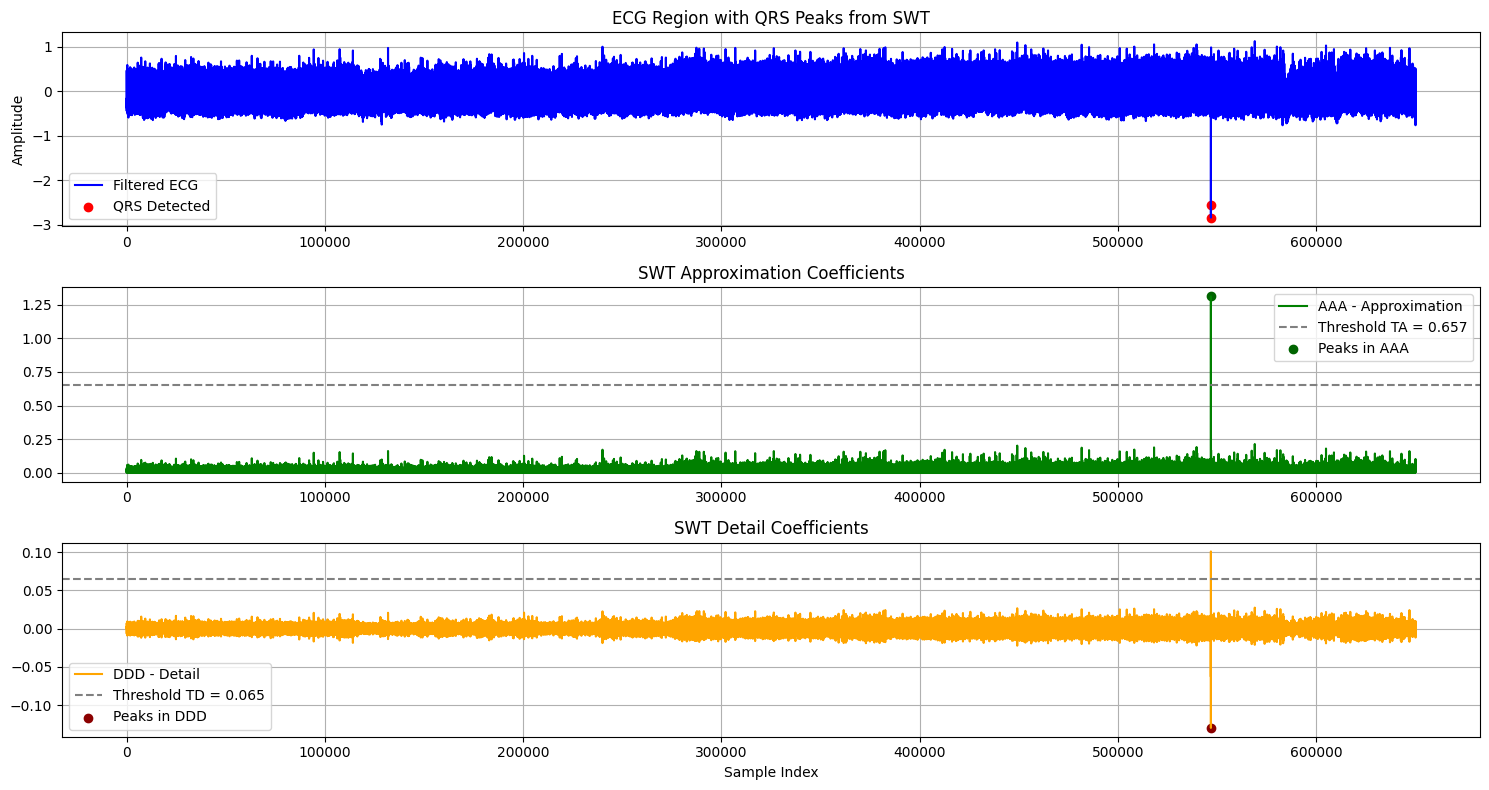

In [ ]:
# === CONTINUE FROM YOUR EXISTING CODE ===
# ecg_region_filtered already exists and is ready for SWT

import pywt
from scipy.signal import find_peaks

# === PADDING FUNCTION ===
def pad_signal_for_swt(signal, level):
    required_length = 2 ** level
    pad_len = (required_length - len(signal) % required_length) % required_length
    return np.pad(signal, (0, pad_len), mode='constant')

# === PREPARE SIGNAL FOR SWT ===
level = 3
padded_ecg = pad_signal_for_swt(ecg_region_filtered, level=level)

# Update time axis to match padded signal
t_padded = np.linspace(0, len(ecg_region_filtered), len(padded_ecg))

# === NORMALIZE ECG SIGNAL (as in paper) ===
norm_ecg = padded_ecg ** 2 / np.max(np.abs(padded_ecg ** 2))

# === APPLY SWT ===
wavelet = 'haar'
coeffs = pywt.swt(norm_ecg, wavelet=wavelet, level=level)

# Extract Level-3 Approximation (AAA) and Detail (DDD)
AAA = coeffs[2][0]
DDD = coeffs[2][1]

# === DYNAMIC THRESHOLDING ===
TA = np.max(np.abs(AAA)) / 2
TD = np.max(np.abs(DDD)) / 2

qrs_a_peaks, _ = find_peaks(np.abs(AAA), height=TA, distance=50)
qrs_d_peaks, _ = find_peaks(np.abs(DDD), height=TD, distance=50)

# Combine both sets of QRS candidates
qrs_indices = np.unique(np.concatenate([qrs_a_peaks, qrs_d_peaks]))

# === PLOT: SWT QRS Detection Results ===
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Plot 1: ECG with Detected QRS Peaks
plt.subplot(3, 1, 1)
plt.plot(t_padded, padded_ecg, label='Filtered ECG', color='blue')
plt.scatter(t_padded[qrs_indices], padded_ecg[qrs_indices], color='red', label='QRS Detected')
plt.title("ECG Region with QRS Peaks from SWT")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Plot 2: Approximation Coefficients
plt.subplot(3, 1, 2)
plt.plot(t_padded, AAA, label="AAA - Approximation", color='green')
plt.axhline(TA, color='gray', linestyle='--', label=f"Threshold TA = {TA:.3f}")
plt.scatter(t_padded[qrs_a_peaks], AAA[qrs_a_peaks], color='darkgreen', label='Peaks in AAA')
plt.title("SWT Approximation Coefficients")
plt.legend()
plt.grid(True)

# Plot 3: Detail Coefficients
plt.subplot(3, 1, 3)
plt.plot(t_padded, DDD, label="DDD - Detail", color='orange')
plt.axhline(TD, color='gray', linestyle='--', label=f"Threshold TD = {TD:.3f}")
plt.scatter(t_padded[qrs_d_peaks], DDD[qrs_d_peaks], color='darkred', label='Peaks in DDD')
plt.title("SWT Detail Coefficients")
plt.xlabel("Sample Index")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# === Choose Zoom Region ===
zoom_start = 60000
zoom_end = 70000

# Convert padded index to match the zoom range
zoom_indices = np.arange(len(padded_ecg))
zoom_mask = (zoom_indices >= zoom_start) & (zoom_indices <= zoom_end)

t_zoom = t_padded[zoom_mask]
ecg_zoom = padded_ecg[zoom_mask]

AAA_zoom = AAA[zoom_mask]
DDD_zoom = DDD[zoom_mask]

# Filter peaks in zoom window
qrs_zoom = qrs_indices[(qrs_indices >= zoom_start) & (qrs_indices <= zoom_end)]
aaa_zoom_peaks = qrs_a_peaks[(qrs_a_peaks >= zoom_start) & (qrs_a_peaks <= zoom_end)]
ddd_zoom_peaks = qrs_d_peaks[(qrs_d_peaks >= zoom_start) & (qrs_d_peaks <= zoom_end)]

# === Full Plot with Zoomed Region ===
plt.figure(figsize=(15, 10))

# Plot 1: Full ECG with QRS
plt.subplot(4, 1, 1)
plt.plot(t_padded, padded_ecg, label='Filtered ECG', color='blue')
plt.scatter(t_padded[qrs_indices], padded_ecg[qrs_indices], color='red', label='QRS Detected')
plt.title("ECG Region with QRS Peaks from SWT")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Plot 2: SWT Approximation Coefficients
plt.subplot(4, 1, 2)
plt.plot(t_padded, AAA, label="AAA - Approximation", color='green')
plt.axhline(TA, color='gray', linestyle='--', label=f"Threshold TA = {TA:.3f}")
plt.scatter(t_padded[qrs_a_peaks], AAA[qrs_a_peaks], color='darkgreen', label='Peaks in AAA')
plt.title("SWT Approximation Coefficients")
plt.legend()
plt.grid(True)

# Plot 3: SWT Detail Coefficients
plt.subplot(4, 1, 3)
plt.plot(t_padded, DDD, label="DDD - Detail", color='orange')
plt.axhline(TD, color='gray', linestyle='--', label=f"Threshold TD = {TD:.3f}")
plt.scatter(t_padded[qrs_d_peaks], DDD[qrs_d_peaks], color='darkred', label='Peaks in DDD')
plt.title("SWT Detail Coefficients")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Plot 4: Zoomed-in ECG and QRS detections
plt.subplot(4, 1, 4)
plt.plot(t_zoom, ecg_zoom, label='Zoomed ECG', color='blue')
plt.scatter(t_padded[qrs_zoom], padded_ecg[qrs_zoom], color='red', label='QRS Detected')
plt.title(f"Zoomed View: ECG and QRS (Samples {zoom_start}-{zoom_end})")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


ECG PREPROCESSED WITH MEDIAN FILTER ON SECOND DATA SET

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


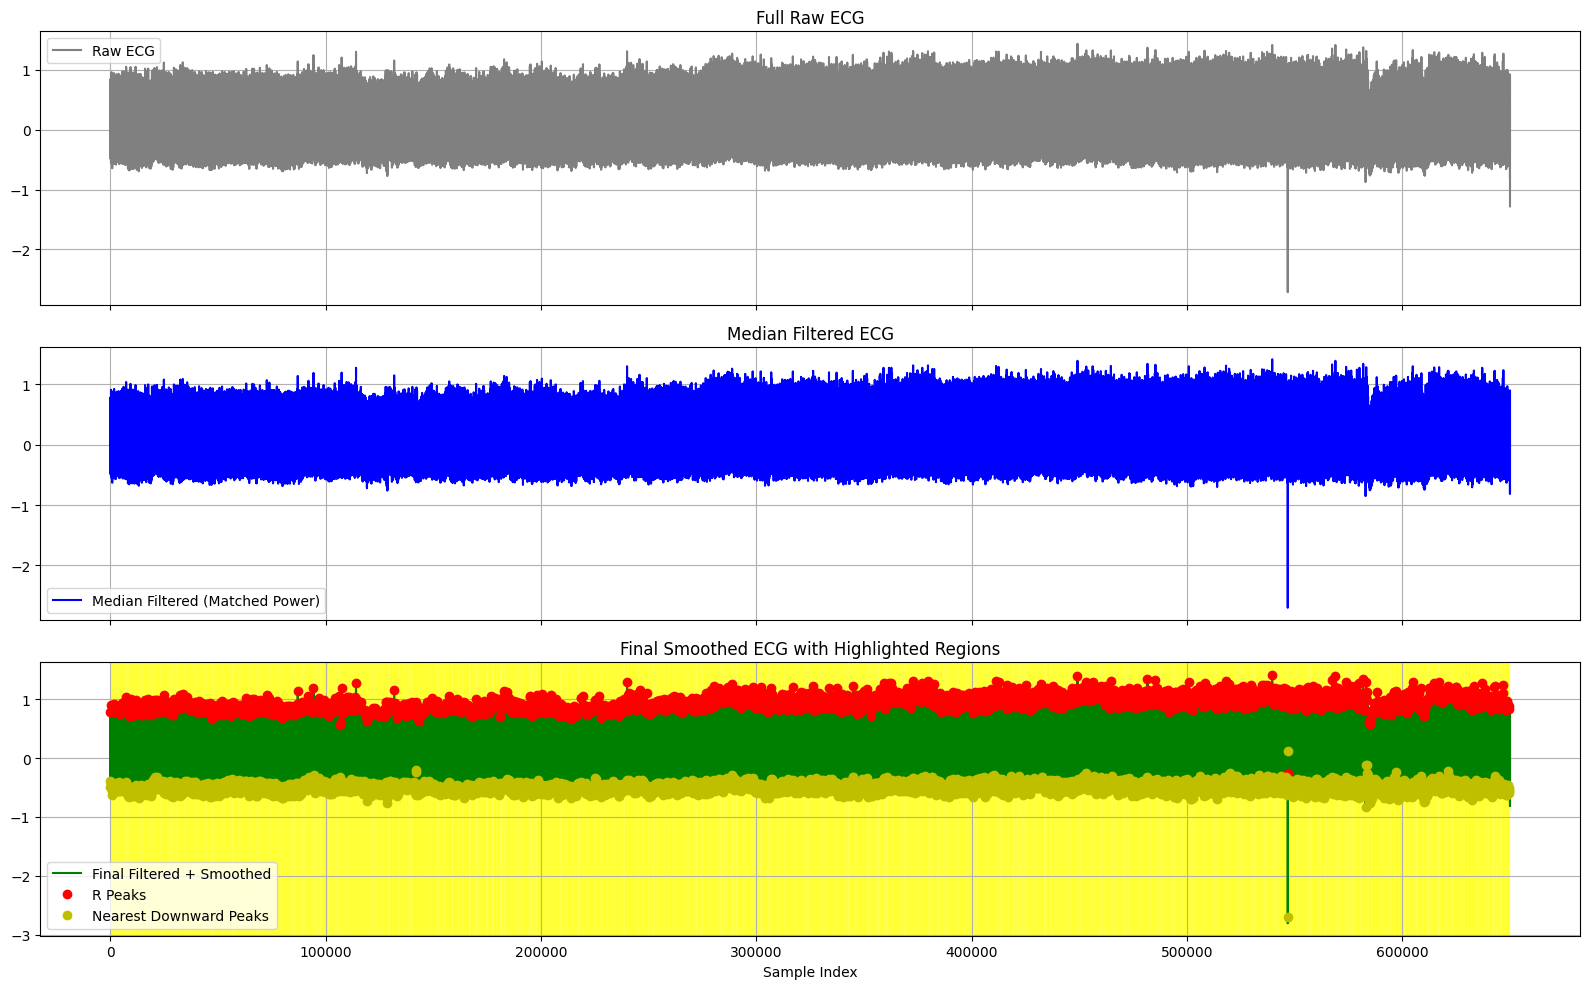

SNR between raw and final filtered ECG: 28.55 dB


interactive(children=(IntSlider(value=0, description='Zoom Start', max=649000, step=500), IntSlider(value=5000…

In [ ]:
# === INSTALL & IMPORTS ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, savgol_filter, medfilt
from biosppy.signals import ecg as biosppy_ecg
from google.colab import drive
from ipywidgets import interact, IntSlider
import wfdb

# === Mount Drive ===
drive.mount('/content/drive')

# === Load ECG Signal from WFDB ===
record_path = "/content/drive/My Drive/Data/100"  # Adjust path as needed
record = wfdb.rdrecord(record_path)
ecg = record.p_signal[:, 0]
fs = record.fs
t = np.arange(len(ecg))

# === Filtering Functions ===
def butter_lowpass_filter(data, cutoff=30, fs=360, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def median_filter(signal, kernel_size=3):
    # kernel_size should be odd, usually small (3,5,7)
    return medfilt(signal, kernel_size=kernel_size)

def match_signal_power(reference, target):
    ref_power = np.mean(reference ** 2)
    tgt_power = np.mean(target ** 2)
    return target * np.sqrt(ref_power / tgt_power)

def calculate_snr(signal, reference):
    noise = signal - reference
    return 10 * np.log10(np.mean(reference**2) / np.mean(noise**2))

# === Apply Median Filter instead of Mittag-Leffler and bandpass ===
ecg_median_filtered = median_filter(ecg, kernel_size=3)  # You can tune kernel_size (try 5,7,9)
ecg_mf_matched = match_signal_power(ecg, ecg_median_filtered)

# === Detect R-peaks and Valleys ===
inverted_ecg = -ecg_mf_matched
downward_peaks, _ = find_peaks(inverted_ecg, distance=10, prominence=0.01)
r_peaks = biosppy_ecg.ecg(signal=ecg_mf_matched, sampling_rate=fs, show=False)['rpeaks']

# === Smoothing Between Valleys Not Including R-peaks ===
ecg_region_filtered = ecg_mf_matched.copy()
nearest_downward_peaks = set()
down_peaks_array = np.array(downward_peaks)

for r in r_peaks:
    left = down_peaks_array[down_peaks_array < r]
    right = down_peaks_array[down_peaks_array > r]
    if len(left): nearest_downward_peaks.add(left[-1])
    if len(right): nearest_downward_peaks.add(right[0])
nearest_downward_peaks = sorted(nearest_downward_peaks)

valid_intervals = []
for i in range(len(nearest_downward_peaks) - 1):
    y1, y2 = nearest_downward_peaks[i], nearest_downward_peaks[i + 1]
    if not any((y1 < r < y2) for r in r_peaks):
        valid_intervals.append((y1, y2))

for y1, y2 in valid_intervals:
    segment = ecg_region_filtered[y1:y2]
    seg_len = len(segment)
    if seg_len < 11: continue
    win_len = min(37, seg_len if seg_len % 2 == 1 else seg_len - 1)
    if win_len < 5: continue
    lowpassed = butter_lowpass_filter(segment, cutoff=30, fs=fs, order=4)
    smoothed = savgol_filter(lowpassed, window_length=win_len, polyorder=3, mode='interp')
    ecg_region_filtered[y1:y2] = smoothed

# === Plot Full Signal ===
fig, axs = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

axs[0].plot(t, ecg, color='gray', label='Raw ECG')
axs[0].set_title('Full Raw ECG')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, ecg_mf_matched, color='blue', label='Median Filtered (Matched Power)')
axs[1].set_title('Median Filtered ECG')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(t, ecg_region_filtered, color='green', label='Final Filtered + Smoothed')
axs[2].plot(t[r_peaks], ecg_region_filtered[r_peaks], 'ro', label='R Peaks')
axs[2].plot(t[nearest_downward_peaks], ecg_region_filtered[nearest_downward_peaks], 'yo', label='Nearest Downward Peaks')
for y1, y2 in valid_intervals:
    axs[2].axvspan(t[y1], t[y2], color='yellow', alpha=0.3)
axs[2].set_title('Final Smoothed ECG with Highlighted Regions')
axs[2].set_xlabel('Sample Index')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# === SNR ===
snr_val = calculate_snr(ecg, ecg_region_filtered)
print(f"SNR between raw and final filtered ECG: {snr_val:.2f} dB")

# === Interactive Zoom Plot ===
def zoom_plot(start=0, width=5000):
    end = min(start + width, len(ecg))
    t_zoom = t[start:end]
    ecg_raw_zoom = ecg[start:end]
    ecg_filtered_zoom = ecg_mf_matched[start:end]
    ecg_final_zoom = ecg_region_filtered[start:end]

    downward_zoom = [i for i in downward_peaks if start <= i < end]
    r_peaks_zoom = [i for i in r_peaks if start <= i < end]

    down_in_range = np.array(downward_peaks)
    nearest_zoom = set()
    for r in r_peaks_zoom:
        left = down_in_range[down_in_range < r]
        right = down_in_range[down_in_range > r]
        if len(left): nearest_zoom.add(left[-1])
        if len(right): nearest_zoom.add(right[0])
    nearest_zoom = sorted([i for i in nearest_zoom if start <= i < end])

    intervals = []
    for i in range(len(nearest_zoom) - 1):
        y1, y2 = nearest_zoom[i], nearest_zoom[i + 1]
        if not any((y1 < r < y2) for r in r_peaks_zoom):
            intervals.append((y1, y2))

    # Plot
    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    axs[0].plot(t_zoom, ecg_raw_zoom, color='gray', label='Raw ECG')
    axs[0].set_title("Zoomed Raw ECG")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(t_zoom, ecg_filtered_zoom, color='blue', label='Median Filtered')
    axs[1].set_title("Zoomed Median Filtered ECG")
    axs[1].grid(True)
    axs[1].legend()

    axs[2].plot(t_zoom, ecg_final_zoom, color='green', label='Final Filtered + Smoothed ECG')
    for y1, y2 in intervals:
        axs[2].axvspan(t[y1], t[y2], color='yellow', alpha=0.3)
    #axs[2].plot(t[r_peaks_zoom], ecg_final_zoom[[r - start for r in r_peaks_zoom]], 'ro', label='R Peaks')
    #axs[2].plot(t[nearest_zoom], ecg_final_zoom[[p - start for p in nearest_zoom]], 'yo', label='Nearest Downward Peaks')
    axs[2].set_title("Zoomed Final ECG with Highlighted Regions")
    axs[2].grid(True)
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# === Interactive Viewer ===
interact(zoom_plot,
         start=IntSlider(min=0, max=len(ecg)-1000, step=500, value=0, description='Zoom Start'),
         width=IntSlider(min=1000, max=30000, step=1000, value=5000, description='Zoom Width'));